<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter4_critical_review_AS2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

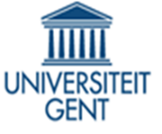<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 4: A Critical Review of the Hybrid Finite-Difference Finite-Element Method**

This Jupyter notebook implements the test cases discussed in chapter 4 of my PhD thesis to verify the hybrid finite-difference finite-element method by Lebbe (1988, 1999).

## Code

Import statements

In [ ]:
from abc import ABC, abstractmethod
from time import sleep
from math import factorial, log
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy as sp
from scipy.linalg import eig, inv, solve
from scipy.special import k0, exp1
from scipy.optimize import minimize, least_squares
import warnings
from scipy.linalg import LinAlgWarning
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt

In [ ]:
# check versions

#print("NumPy", np.__version__)
#print("Matplotlib", matplotlib.__version__)
#print("SciPy", sp.__version__)

NumPy  1.22.4
Matplotlib 3.7.1
SciPy 1.10.1


Abstract base class for all model classes

In [ ]:
class Model(ABC):

    def __init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q):
        self.t1 = t1
        self.nt = nt
        self.r1 = r1
        self.nr = nr
        self.a = a
        self.D = np.array(D)[:, np.newaxis]
        self.Kh = np.array(Kh)[:, np.newaxis]
        self.Kv = np.array(Kv)[:, np.newaxis]
        self.Ss = np.array(Ss)[:, np.newaxis]
        self.Q = np.array(Q)[:, np.newaxis]
        self.nl = self.D.shape[0]
        self.c = np.Inf * np.ones((self.nl + 1, 1))  # (nl+1, 1)
        self.c[1:-1, :] = (self.D[1:] / self.Kv[1:] + self.D[:-1] / self.Kv[:-1]) / 2.0
        self.T = self.Kh * self.D  # (nl, 1)
        self.S = self.Ss * self.D  # (nl, 1)
        self.s = None
        self.no_warnings = True

    @property
    def t(self):
        return self.t1 * self.a ** (np.arange(self.nt+1))

    @property
    def r(self):
        return self.r1 * self.a ** (np.arange(self.nr))

    @abstractmethod
    def _initialize(self):
        pass

    def solve(self, *j):
        self._initialize()
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
            self._solve(*j)

    @abstractmethod
    def _solve(self, *j):
        pass

Abstract base class for numerical model classes

In [ ]:
class NumericalModel(Model):

    def __init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q):
        Model.__init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)

    def _initialize(self):
        i = 2 * np.arange(self.nr) - 1
        self._hs = np.pi * self.r1 ** 2 * self.a ** i * (self.a ** 2 - 1)
        self._n = self.nr * self.nl
        self._idx = np.diag_indices(self._n)
        self._b0 = np.zeros((self._n,))
        self._b0[::self.nr] = -self.Q.flatten()
        self._A0 = np.zeros((self._n, self._n))
        self._dS = None
        self._A = None
        self._b = None

    @abstractmethod
    def _set_A_b(self, k):
        pass

    def _solve(self):
        self.s = np.zeros((self._b0.shape[0], self.nt + 1))
        for k in range(self.nt):
            self._dS /= self.a
            self._set_A_b(k)
            self.s[:, k + 1] = solve(self._A, self._b)

    def solve(self):
        Model.solve(self)
        self.s = np.reshape(self.s, (self.nl, self.nr, self.nt + 1))

Louwyck's finite-difference method (Louwyck, 2011; Louwyck et al. 2012)

In [ ]:
class Louwyck(NumericalModel):

    def __init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q):
        NumericalModel.__init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)

    def _qhc(self):
        qhc = np.zeros((self.nl, self.nr + 1))
        qhc[:, 1:-1] = 2.0 * np.pi * self.T / np.log(self.a)
        return qhc

    def _qvc(self):
        return np.outer(1 / self.c, self._hs)

    def _initialize(self):
        NumericalModel._initialize(self)
        irow, icol = self._idx
        nr = self.nr
        qhc, qvc = self._qhc(), self._qvc()
        self._dS = (np.outer(self.S, self._hs) / self.t1 / (1 - 1 / self.a)).flatten()
        self._A0[irow[:-1]+1, icol[:-1]] = self._A0[irow[:-1], icol[:-1]+1] = qhc[:, 1:].flatten()[:-1]
        self._A0[irow[:-nr]+nr, icol[:-nr]] = self._A0[irow[:-nr], icol[:-nr]+nr] = qvc[1:, :].flatten()[:-nr]
        self._A0[irow, icol] = -(qhc[:, :-1] + qhc[:, 1:] + qvc[:-1, :] + qvc[1:, :]).flatten()

    def _set_A_b(self, k):
        self._b = self._b0 - self._dS * self.s[:, k]
        self._A = self._A0.copy()
        self._A[self._idx] -= self._dS

Lebbe's hybrid finite-difference finite-element method (Lebbe, 1988, 1999)

In [ ]:
class Lebbe(NumericalModel):

    def __init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q):
        NumericalModel.__init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
        self.use_thiem = True
        self.radial_interpolation = True
        self.vertical_interpolation = True
        self.vertical_interpolation_correction = True
        self.time_interpolation = True

    def __interpolation_constants(self):
        # h1, h2, h3: (1, nr)
        self._h1 = np.zeros((1, self.nr))
        self._h3 = np.zeros((1, self.nr))
        if self.radial_interpolation:
            denominator = 2 * (self.a ** 2 - 1) * np.log(self.a)
            self._h1[0, 1:] = (self.a - np.log(self.a) - 1) / denominator
            self._h3[0, :-1] = self.a * (self.a * np.log(self.a) - self.a + 1) / denominator
        self._h2 = 1 - self._h1 - self._h3
        # v1, v2, v3: (nl, 1)
        if self.vertical_interpolation:
            D = np.inf * np.ones((self.nl + 2, 1))
            D[1:-1, :] = self.D
            denominator = 4 * (D[:-1] + D[1:])
            self._v1 = self.D / denominator[:-1]
            self._v3 = self.D / denominator[1:]
            if self.vertical_interpolation_correction:
                f1 = ((1 - np.abs((self.Kh[1:] - self.Kh[:-1]) / (self.Kh[1:] + self.Kh[:-1]))) *
                      (1 - np.abs((self.Kh[1:] - self.Kv[1:]) / (self.Kh[1:] + self.Kv[1:]))) *
                      (1 - np.abs((self.Kh[:-1] - self.Kv[1:]) / (self.Kh[:-1] + self.Kv[1:]))) *
                      (1 - np.abs((self.Ss[1:] - self.Ss[:-1]) / (self.Ss[1:] + self.Ss[:-1])))) ** 0.25
                f3 = ((1 - np.abs((self.Kh[:-1] - self.Kh[1:]) / (self.Kh[1:] + self.Kh[:-1]))) *
                      (1 - np.abs((self.Kh[:-1] - self.Kv[:-1]) / (self.Kh[:-1] + self.Kv[:-1]))) *
                      (1 - np.abs((self.Kh[1:] - self.Kv[:-1]) / (self.Kh[1:] + self.Kv[:-1]))) *
                      (1 - np.abs((self.Ss[:-1] - self.Ss[1:]) / (self.Ss[1:] + self.Ss[:-1])))) ** 0.25
                self._v1[1:] *= f1 / 10
                self._v3[:-1] *= f3 / 10
        else:
            self._v1 = np.zeros((self.nl, 1))
            self._v3 = np.zeros((self.nl, 1))
        self._v2 = 1 - self._v1 - self._v3
        # hv's: (nl, nr)
        self._h1v1 = np.outer(self._v1, self._h1)
        self._h1v2 = np.outer(self._v2, self._h1)
        self._h1v3 = np.outer(self._v3, self._h1)
        self._h2v1 = np.outer(self._v1, self._h2)
        self._h2v2 = np.outer(self._v2, self._h2)
        self._h2v3 = np.outer(self._v3, self._h2)
        self._h3v1 = np.outer(self._v1, self._h3)
        self._h3v2 = np.outer(self._v2, self._h3)
        self._h3v3 = np.outer(self._v3, self._h3)
        # t1, t2: scalars
        if self.time_interpolation:
            self._t2 = (self.a * np.log(self.a) - self.a + 1) / np.log(self.a) / (self.a - 1)
        else:
            self._t2 = 1.0
        self._t1 = 1.0 - self._t2

    def _initialize(self):
        NumericalModel._initialize(self)
        irow, icol = self._idx
        nr = self.nr
        # h1, h2, h3, v1, v2, v3, t1, t2
        self.__interpolation_constants()
        # A0: (n, n)
        T_dr = np.zeros((self.nl, nr + 2))  # (nl, nr+2)
        if self.use_thiem:
            T_dr[:, 1:-1] = 2 * np.pi / np.log(self.a) * self.T
        else:
            T_dr[:, 1:-1] = 2 * np.pi * np.sqrt(self.a) / (self.a - 1) * self.T
        TT_dr = T_dr[:, :-2] + T_dr[:, 2:]  # (nl, nr)
        cvm = 1 / self.c[:-1] + 1 / self.c[1:]  # (nl, 1)
        cvm_hs = -np.outer(cvm, self._hs)  # (nl, nr)
        self._A0[irow, icol] = (cvm_hs * self._h2 - TT_dr * self._v2).flatten()  # s(i,j)
        self._A0[irow[:-1]+1, icol[:-1]] = (cvm_hs * self._h1 + T_dr[:, :-2] * self._v2).flatten()[1:]  # s(i-1,j)
        self._A0[irow[:-1], icol[:-1]+1] = (cvm_hs * self._h3 + T_dr[:, 2:] * self._v2).flatten()[:-1]  # s(i+1,j)
        cv_hs = np.outer(1 / self.c[1:-1], self._hs)  # (nl-1, nr)
        self._A0[irow[:-nr]+nr, icol[:-nr]] = (cv_hs * self._h2 - TT_dr[1:, :] * self._v1[1:]).flatten()  # s(i,j-1)
        self._A0[irow[:-nr-1]+nr+1, icol[:-nr-1]] = (cv_hs * self._h1 + T_dr[1:, :-2] * self._v1[1:]).flatten()[1:]  # s(i-1,j-1)
        self._A0[irow[1:-nr+1]+nr-1, icol[1:-nr+1]] = (cv_hs * self._h3 + T_dr[1:, 2:] * self._v1[1:]).flatten()  # s(i+1,j-1)
        self._A0[irow[:-nr], icol[:-nr]+nr] = (cv_hs * self._h2 - TT_dr[:-1, :] * self._v3[:-1]).flatten()  # s(i,j+1)
        self._A0[irow[:-nr], icol[:-nr]+nr-1] = (cv_hs * self._h1 + T_dr[:-1, :-2] * self._v3[:-1]).flatten()  # s(i-1,j+1)
        self._A0[irow[:-nr-1], icol[:-nr-1]+nr+1] = (cv_hs * self._h3 + T_dr[:-1, 2:] * self._v3[:-1]).flatten()[:-1]  # s(i+1,j+1)

        # dS: (n, n)
        S_hs_dt = np.outer(self.S, self._hs) / self.t1 / (1 - 1/self.a)
        self._dS = np.zeros((self._n, self._n))
        self._dS[irow, icol] = (S_hs_dt * self._h2v2).flatten()  # s(i,j)
        self._dS[irow[:-1]+1, icol[:-1]] = (S_hs_dt * self._h1v2).flatten()[1:]  # s(i-1,j)
        self._dS[irow[:-1], icol[:-1]+1] = (S_hs_dt * self._h3v2).flatten()[:-1]  # s(i+1,j)
        self._dS[irow[:-nr]+nr, icol[:-nr]] = (S_hs_dt * self._h2v1).flatten()[nr:]  # s(i,j-1)
        self._dS[irow[:-nr-1]+nr+1, icol[:-nr-1]] = (S_hs_dt * self._h1v1).flatten()[nr+1:]  # s(i-1,j-1)
        self._dS[irow[1:-nr+1]+nr-1, icol[1:-nr+1]] = (S_hs_dt * self._h3v1).flatten()[nr:]  # s(i+1,j-1)
        self._dS[irow[:-nr], icol[:-nr]+nr] = (S_hs_dt * self._h2v3).flatten()[:-nr]  # s(i,j+1)
        self._dS[irow[:-nr], icol[:-nr]+nr-1] = (S_hs_dt * self._h1v3).flatten()[:-nr]  # s(i-1,j+1)
        self._dS[irow[:-nr-1], icol[:-nr-1]+nr+1] = (S_hs_dt * self._h3v3).flatten()[:-nr-1]  # s(i+1,j+1)

    def _set_A_b(self, k):
        self._b = self._b0 - np.dot(self._dS, self.s[:, k]) - self._t1 * np.dot(self._A0, self.s[:, k])
        self._A = self._t2 * self._A0 - self._dS

Stehfest's algorithm (Stehfest, 1970)

In [ ]:
def __fac(x):
    return float(factorial(x))


def Stehfest(F, t, ns=16):
    ns2 = ns // 2

    def W(j):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        w = 0
        for k in range(k_0, m + 1):
            w += k ** ns2 * __fac(2 * k) / __fac(ns2 - k) / __fac(k) / __fac(k - 1) / __fac(j - k) / __fac(2 * k - j)
        w *= (-1) ** (ns2 + j)
        return w

    ln2t = log(2) / t
    f = 0.
    for i in range(1, ns + 1):
        f = f + W(i) * F(i * ln2t)
    f = ln2t * f
    return f

Hemker's semi-analytical method (Hemker, 1985, 1999)

In [ ]:
class Hemker(Model):

    def __init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q):
        Model.__init__(self, t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
        self.ns = 12

    def _initialize(self):
        self._d = self.S / self.T  # (nl, 1)
        self._q = self.Q / 2 / np.pi / self.T  # (nl, 1)
        Tc1 = 1 / (self.T * self.c[:-1])  # (nl, 1)
        Tc2 = 1 / (self.T * self.c[1:])  # (nl, 1)
        self._idx = np.diag_indices(self.nl)
        irow, icol = self._idx
        self._A0 = np.zeros((self.nl, self.nl))  # (nl, nl)
        self._A0[irow, icol] = (Tc1 + Tc2).flatten()
        self._A0[irow[:-1], icol[:-1] + 1] = -Tc2.flatten()[:-1]
        self._A0[irow[:-1] + 1, icol[:-1]] = -Tc1.flatten()[1:]

    def _sp(self, r, p):
        A = self._A0.copy()  # (nl, nl)
        A[self._idx] += self._d.flatten() * p
        w, V = eig(A)  # (nl, ), (nl, nl)
        sw = np.sqrt(np.real(w))  # (nl, )
        b = np.dot(inv(V), self._q / p)  # (nl, 1)
        K = np.zeros((self.nl, self.nl))  # (nl, nl)
        K[self._idx] = k0(r * sw)
        return mdot((V, K, b))  # (nl, 1)

    def _solve(self, j=None):
        r_all = self.r[:] if j is None else self.r[[j]]
        self.s = np.zeros((self.nl, len(r_all), self.nt + 1))
        for j, r in enumerate(r_all):
            for k, t in enumerate(self.t):
                self.s[:, j, k] = Stehfest(lambda p: self._sp(r, p), t, self.ns).flatten()

## Test cases

### Synthetic pumping test (Lebbe & De Breuck, 1995)

See also Lebbe (1999) p 257-267

Input

In [ ]:
a = 10**0.1
r1 = 0.1
nr = 70
t1_osc = 0.1 / 1440
nt_osc = 45
t1 = 1e-3 / 1440
nt = 65

In [ ]:
D = np.array([1, 9, 10/3, 10/3, 10/3, 10])
Kh = np.array([10, 10, 0.5, 0.5, 0.5, 10])
Kv = np.array([10, 10, 0.1, 0.1, 0.1, 10])
Ss = np.array([0.2, 4e-4, 4e-5, 4e-5, 4e-5, 8e-5])
Q = np.array([0, 0, 0, 0, 0, 180])

Simulations

In [ ]:
hemker = Hemker(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
hemker.solve()
louwyck = Louwyck(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
louwyck.solve()
lebbe = Lebbe(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
lebbe.solve()
lebbe_osc = Lebbe(t1_osc, nt_osc, r1, nr, a, D, Kh, Kv, Ss, Q)  # model suffering from spurious oscillations
lebbe_osc.solve()

Interpolation constants in Lebbe's method

In [ ]:
lebbe._h1[0, 1], lebbe._h2[0, 1], lebbe._h3[0, 1]  # radial

(0.10642864139303315, 0.7489012629182382, 0.14467009568872868)

In [ ]:
np.hstack((lebbe._v1, lebbe._v2, lebbe._v3))  # vertical

array([[0.00000000e+00, 9.99371597e-01, 6.28402749e-04],
       [5.65562474e-03, 9.90668026e-01, 3.67634895e-03],
       [6.98629837e-04, 9.92084492e-01, 7.21687836e-03],
       [7.21687836e-03, 9.85566243e-01, 7.21687836e-03],
       [7.21687836e-03, 9.91888876e-01, 8.94245410e-04],
       [5.22858061e-03, 9.94771419e-01, 0.00000000e+00]])

In [ ]:
lebbe._t1, lebbe._t2  # temporal

(0.48082872517090114, 0.5191712748290989)

Checking the drawdown at the outer boundary

In [ ]:
print(hemker.s[:, -1, -1])
print(louwyck.s[:, -1, -1])
print(lebbe.s[:, -1, -1])
print(lebbe_osc.s[:, -1, -1])

[0. 0. 0. 0. 0. 0.]
[7.00002613e-116 8.25744653e-116 5.07999248e-115 1.33717643e-114
 2.16812220e-114 2.59751995e-114]
[4.85259153e-34 5.28933462e-34 1.97501196e-33 4.80268454e-33
 7.66279415e-33 9.16033713e-33]
[4.85228965e-34 5.28893032e-34 1.97463479e-33 4.80168634e-33
 7.66127157e-33 9.15862192e-33]


Observations

In [ ]:
# obs well indices
jobs = np.zeros(3, dtype=int)
jobs[0] = np.argmin(np.abs(hemker.r - 5.01))
jobs[1] = np.argmin(np.abs(hemker.r - 15.85))
jobs[2] = np.argmin(np.abs(hemker.r - 50.12))
print(hemker.r[jobs])

[ 5.01187234 15.84893192 50.11872336]


In [ ]:
# obs time indices
tobs = [1, 1.25, 1.6, 2, 2.5, 3.2, 4, 5, 6.3, 7.9, 10, 12.6, 15.9, 20, 25.1, 31.6, 39.8, 50.1,
        63, 79, 100, 126, 159, 200, 251, 316, 398, 501, 631, 794, 1000, 1259, 1585]
kobs = np.zeros(len(tobs), dtype=int)
err = np.zeros(len(tobs))
for k, t in enumerate(tobs):
    kobs[k] = np.argmin(np.abs(hemker.t * 1440 - t))
    err[k] = np.abs(hemker.t[kobs[k]] * 1440 - t)
print(np.max(err))
print(kobs)

0.510680753888181
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62]


In [ ]:
# layer indices with obs
iobs = np.array([5, 3], dtype=int)  # pumped layer first

In [ ]:
# get observed drawdowns in cm versus time in minutes
t = hemker.t[kobs] * 1440
s_hemker = np.reshape(hemker.s[iobs][:, jobs][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_hemker = np.hstack((hemker.s[5, 0, kobs][:, np.newaxis] * 100, s_hemker))
b_obs = s_hemker > 0.5
s_hemker[~b_obs] = np.nan
s_louw = np.reshape(louwyck.s[iobs][:, jobs][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_louw = np.hstack((louwyck.s[5, 0, kobs][:, np.newaxis] * 100, s_louw))
s_lebbe = np.reshape(lebbe.s[iobs][:, jobs][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_lebbe = np.hstack((lebbe.s[5, 0, kobs][:, np.newaxis] * 100, s_lebbe))
s_osc = np.reshape(lebbe_osc.s[iobs][:, jobs][:, :, kobs-20], (len(iobs) * len(jobs), len(kobs))).T * 100
s_osc = np.hstack((lebbe_osc.s[5, 0, kobs-20][:, np.newaxis] * 100, s_osc))

Plot

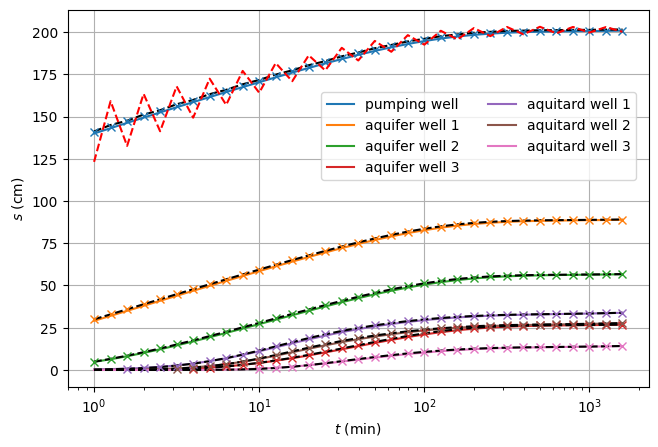

In [ ]:
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(fig.get_figwidth() * 1.25)
fig.set_figheight(fig.get_figheight() * 1.25)
ax.semilogx(t, s_louw,'-');
ax.set_prop_cycle(color=colors)
ax.semilogx(t, s_lebbe,'k--');
ax.set_prop_cycle(color=colors)
ax.semilogx(t, s_hemker,'x');
ax.semilogx(t, s_osc[:, 0], 'r--')
leg = ax.legend(['pumping well', 'aquifer well 1', 'aquifer well 2', 'aquifer well 3', 'aquitard well 1',
                'aquitard well 2', 'aquitard well 3'], ncol=2, loc='upper right', bbox_to_anchor=(0.99, 0.8));
ax.grid();
ax.set_xlabel("$t$ (min)");
ax.set_ylabel("$s$ (cm)");

RMSE

In [ ]:
RMSE = lambda s_ref, s: np.sqrt(np.mean(np.square(s_ref - s)))
print(RMSE(s_hemker[b_obs], s_louw[b_obs]))
print(RMSE(s_hemker[b_obs], s_lebbe[b_obs]))
print(RMSE(s_hemker[b_obs], s_osc[b_obs]))

0.5163774468316478
0.2767768195586895
3.066205570040936


**Higher resolution models**

In [ ]:
a = 10**0.01
r1 = 0.1
nr = 700
t1_osc = 0.1 / 1440
nt_osc = 450
t1 = 1e-3 / 1440
nt = 650

In [ ]:
D = np.array([1, 9, 10/3, 10/3, 10/3, 10])
Kh = np.array([10, 10, 0.5, 0.5, 0.5, 10])
Kv = np.array([10, 10, 0.1, 0.1, 0.1, 10])
Ss = np.array([0.2, 4e-4, 4e-5, 4e-5, 4e-5, 8e-5])
Q = np.array([0, 0, 0, 0, 0, 180])

Simulations

In [ ]:
louwyck = Louwyck(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
louwyck.solve()
lebbe = Lebbe(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
lebbe.solve()
lebbe_osc = Lebbe(t1_osc, nt_osc, r1, nr, a, D, Kh, Kv, Ss, Q)
lebbe_osc.solve()

Interpolation constants in Lebbe's method

In [ ]:
lebbe._h1[0, 1], lebbe._h2[0, 1], lebbe._h3[0, 1]  # radial

(0.12308676942613041, 0.7499889549645073, 0.12692427560936229)

In [ ]:
np.hstack((lebbe._v1, lebbe._v2, lebbe._v3))  # vertical

array([[0.00000000e+00, 9.99371597e-01, 6.28402749e-04],
       [5.65562474e-03, 9.90668026e-01, 3.67634895e-03],
       [6.98629837e-04, 9.92084492e-01, 7.21687836e-03],
       [7.21687836e-03, 9.85566243e-01, 7.21687836e-03],
       [7.21687836e-03, 9.91888876e-01, 8.94245410e-04],
       [5.22858061e-03, 9.94771419e-01, 0.00000000e+00]])

In [ ]:
lebbe._t1, lebbe._t2  # temporal

(0.4980811960446311, 0.5019188039553689)

Checking the drawdown at the outer boundary

In [ ]:
print(louwyck.s[:, -1, -1])
print(lebbe.s[:, -1, -1])
print(lebbe_osc.s[:, -1, -1])

[-0. -0. -0. -0. -0. -0.]
[-5.78988722e-217 -6.21875887e-217  3.31947717e-216  2.05061652e-215
  7.06708325e-215  1.26454115e-214]
[-5.81496964e-217 -6.48382985e-217  2.62249355e-216  1.80722399e-215
  7.40612652e-215  1.24645153e-214]


Observations

In [ ]:
# obs well indices
jobs = np.zeros(3, dtype=int)
jobs[0] = np.argmin(np.abs(lebbe.r - 5.01))
jobs[1] = np.argmin(np.abs(lebbe.r - 15.85))
jobs[2] = np.argmin(np.abs(lebbe.r - 50.12))
print(hemker.r[jobs])

[ 5.01187234 15.84893192 50.11872336]


In [ ]:
hemker = Hemker(t1, nt, r1, nr, a, D, Kh, Kv, Ss, Q)
hemker.solve(np.insert(jobs, 0, 0))

In [ ]:
# obs time indices
tobs = [1, 1.25, 1.6, 2, 2.5, 3.2, 4, 5, 6.3, 7.9, 10, 12.6, 15.9, 20, 25.1, 31.6, 39.8, 50.1,
        63, 79, 100, 126, 159, 200, 251, 316, 398, 501, 631, 794, 1000, 1259, 1585]
kobs = np.zeros(len(tobs), dtype=int)
err = np.zeros(len(tobs))
for k, t in enumerate(tobs):
    kobs[k] = np.argmin(np.abs(hemker.t * 1440 - t))
    err[k] = np.abs(hemker.t[kobs[k]] * 1440 - t)
print(np.max(err))
print(kobs)

0.5106807538912221
[300 310 320 330 340 351 360 370 380 390 400 410 420 430 440 450 460 470
 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620]


In [ ]:
# layer indices with obs
iobs = np.array([5, 3], dtype=int)  # pumped layer first

In [ ]:
# get observed drawdowns in cm versus time in minutes
t = hemker.t[kobs] * 1440
s_hemker = np.reshape(hemker.s[iobs][:, 1:][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_hemker = np.hstack((hemker.s[5, 0, kobs][:, np.newaxis] * 100, s_hemker))
b_obs = s_hemker > 0.5
s_hemker[~b_obs] = np.nan
s_louw = np.reshape(louwyck.s[iobs][:, jobs][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_louw = np.hstack((louwyck.s[5, 0, kobs][:, np.newaxis] * 100, s_louw))
s_lebbe = np.reshape(lebbe.s[iobs][:, jobs][:, :, kobs], (len(iobs) * len(jobs), len(kobs))).T * 100
s_lebbe = np.hstack((lebbe.s[5, 0, kobs][:, np.newaxis] * 100, s_lebbe))
s_osc = np.reshape(lebbe_osc.s[iobs][:, jobs][:, :, kobs-200], (len(iobs) * len(jobs), len(kobs))).T * 100
s_osc = np.hstack((lebbe_osc.s[5, 0, kobs-200][:, np.newaxis] * 100, s_osc))

Plot

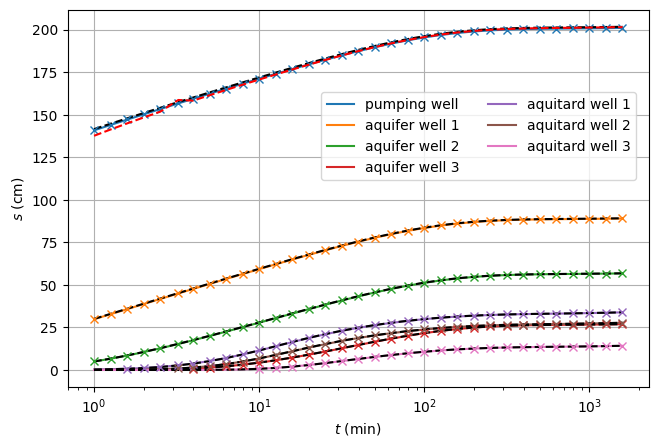

In [ ]:
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(fig.get_figwidth() * 1.25)
fig.set_figheight(fig.get_figheight() * 1.25)
ax.semilogx(t, s_louw,'-');
ax.set_prop_cycle(color=colors)
ax.semilogx(t, s_lebbe,'k--');
ax.set_prop_cycle(color=colors)
ax.semilogx(t, s_hemker,'x');
ax.semilogx(t, s_osc[:, 0], 'r--')
leg = ax.legend(['pumping well', 'aquifer well 1', 'aquifer well 2', 'aquifer well 3', 'aquitard well 1',
                'aquitard well 2', 'aquitard well 3'], ncol=2, loc='upper right', bbox_to_anchor=(0.99, 0.8));
ax.grid();
ax.set_xlabel("$t$ (min)");
ax.set_ylabel("$s$ (cm)");

RMSE

In [ ]:
print(RMSE(s_hemker[b_obs], s_louw[b_obs]))
print(RMSE(s_hemker[b_obs], s_lebbe[b_obs]))
print(RMSE(s_hemker[b_obs], s_osc[b_obs]))

0.048579063719909325
0.2732617284764859
0.464581438151868


### Theis (1935)

In [ ]:
def theis(r, t, D, Kh, Ss, Q):
    t, r = np.meshgrid(t, r)
    u = r**2 * Ss / 4 / t / Kh
    return Q / 4 / np.pi / Kh / D * exp1(u)

In [ ]:
def error(s_ref, s, i, j):
    return np.abs(s_ref[j, :] - s[i, j, :]) / s_ref[j, :]

In [ ]:
Kh = [1]
Kv = [np.inf]
Ss = [1]
D = [1]
Q = [1]

nr, nt = 100, 150
r1 = 1e-5  # * 10 to dampen
t1 = 1e-8  # / 100 to dampen
a = 10**0.1

In [ ]:
hemker = Hemker(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
hemker.solve(0)
louwyck = Louwyck(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
louwyck.solve()
no_thiem = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
no_thiem.use_thiem = False
no_thiem.radial_interpolation = False
no_thiem.time_interpolation = False
no_thiem.solve()
radial = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
radial.time_interpolation = False
radial.solve()
temp = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
temp.radial_interpolation = False
temp.solve()
lebbe = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
lebbe.use_thiem = True
lebbe.solve()
s_th = theis(hemker.r, hemker.t, D[0], Kh[0], Ss[0], Q[0])

In [ ]:
# errors
e_hemker = error(s_th, hemker.s, 0, 0)
e_no_thiem = error(s_th, no_thiem.s, 0, 0)
e_radial = error(s_th, radial.s, 0, 0)
e_temp = error(s_th, temp.s, 0, 0)
e_lebbe = error(s_th, lebbe.s, 0, 0)
e_louw = error(s_th, louwyck.s, 0, 0)
e = np.vstack((e_louw, e_lebbe, e_radial, e_temp, e_no_thiem, e_hemker))

In [ ]:
s = np.vstack((louwyck.s[0, 0, :], lebbe.s[0, 0, :], radial.s[0, 0, :],
               temp.s[0, 0, :], no_thiem.s[0, 0, :], hemker.s[0, 0, :]))

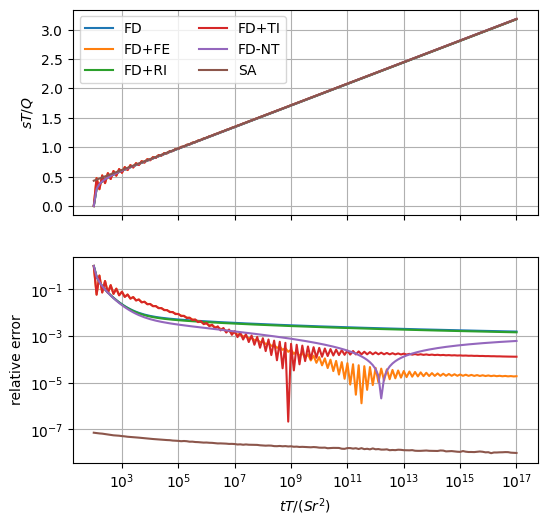

In [ ]:
# plot
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(fig.get_figheight() * 1.5)
u = hemker.t / hemker.r[0]**2
ax0.semilogx(u, s.T, '-');
ax1.loglog(u, e.T, '-');
ax0.legend(["FD", "FD+FE", "FD+RI", "FD+TI", "FD-NT", "SA"], ncol=2);
ax0.set_ylabel("$sT/Q$")
ax1.set_xlabel("$tT/(Sr^2)$")
ax1.set_ylabel("relative error")
#ax0.set_xlim([1e-7, 1e8]);
#ax1.set_ylim((1e-9, 1e0));
ax0.grid()
ax1.grid()

### Three-layer system

In [ ]:
def error(s_ref, s, i, j):
    return np.abs(s_ref[i, j, :] - s[i, j, :]) / s_ref[i, j, :]

In [ ]:
a = 10**0.1
r1 = 0.001
nr = 100
t1 = 1e-6
nt = 130

Homogeneous system

In [ ]:
D = np.array([1, 1, 1])
D = D / D.sum()
Kh = np.array([1, 1, 1])
Kh = Kh / Kh.sum()
Kv = np.array([1, 1, 1])
Kv = Kv / Kv.sum()
Ss = np.array([1, 1, 1])
Ss = Ss / Ss.sum()
Q = np.array([0, 1, 0])

In [ ]:
hemker = Hemker(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
hemker.solve(0)
louwyck = Louwyck(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
louwyck.solve()
radial = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
radial.radial_interpolation = False
radial.time_interpolation = False
radial.vertical_interpolation = False
radial.vertical_interpolation_correction = False
radial.solve()
temp = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
temp.radial_interpolation = False
temp.time_interpolation = True
temp.vertical_interpolation = False
temp.vertical_interpolation_correction = False
temp.solve()
vert = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
vert.radial_interpolation = False
vert.time_interpolation = False
vert.vertical_interpolation = True
vert.vertical_interpolation_correction = False
vert.solve()
lebbe = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
lebbe.no_thiem = False
lebbe.vertical_interpolation_correction = True
lebbe.solve()

In [ ]:
# vertical interpolation constants
print(np.hstack((vert._v1, vert._v2, vert._v3)))
print()
print(np.hstack((lebbe._v1, lebbe._v2, lebbe._v3)))

[[0.    0.875 0.125]
 [0.125 0.75  0.125]
 [0.125 0.875 0.   ]]

[[0.     0.9875 0.0125]
 [0.0125 0.975  0.0125]
 [0.0125 0.9875 0.    ]]


In [ ]:
s0 = np.vstack((louwyck.s[0, 0, :], lebbe.s[0, 0, :], radial.s[0, 0, :],
                temp.s[0, 0, :], vert.s[0, 0, :], hemker.s[0, 0, :]))
s1 = np.vstack((louwyck.s[1, 0, :], lebbe.s[1, 0, :], radial.s[1, 0, :],
                temp.s[1, 0, :], vert.s[1, 0, :], hemker.s[1, 0, :]))

In [ ]:
# errors
e_louw = error(hemker.s, louwyck.s, 1, 0)
e_lebbe = error(hemker.s, lebbe.s, 1, 0)
e_radial = error(hemker.s, radial.s, 1, 0)
e_temp = error(hemker.s, temp.s, 1, 0)
e_vert = error(hemker.s, vert.s, 1, 0)
e = np.vstack((e_louw, e_lebbe, e_radial, e_temp, e_vert))

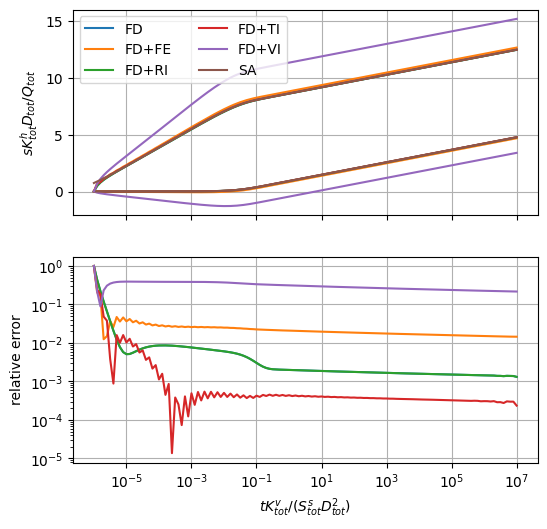

In [ ]:
# plot
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(fig.get_figheight() * 1.5)
ax0.semilogx(hemker.t, s0.T, '-');
ax0.set_prop_cycle(color=colors)
ax0.semilogx(hemker.t, s1.T, '-');
ax1.loglog(hemker.t, e.T, '-');
ax0.legend(["FD", "FD+FE", "FD+RI", "FD+TI", "FD+VI", "SA"], ncol=2);
ax0.set_ylabel("$sK_{tot}^hD_{tot}/Q_{tot}$")
ax1.set_xlabel("$tK_{tot}^v/(S_{tot}^sD_{tot}^2)$")
ax1.set_ylabel("relative error")
#ax0.set_xlim([1e-7, 1e8]);
#ax1.set_ylim((1e-9, 1e0));
ax0.grid()
ax1.grid()

Heterogeneous system

In [ ]:
D = np.array([1, 1, 1])
D = D / D.sum()
Kh = np.array([1, 100, 1])  # pumped layer x 100
Kh = Kh / Kh.sum()
Kv = np.array([1, 1000, 1])  # pumped layer x 1000
Kv = Kv / Kv.sum()
Ss = np.array([1, 10, 1])  # pumped layer x 1000
Ss = Ss / Ss.sum()
Q = np.array([0, 1, 0])

In [ ]:
hemker = Hemker(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
hemker.solve(0)
louwyck = Louwyck(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
louwyck.solve()
radial = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
radial.radial_interpolation = False
radial.time_interpolation = False
radial.vertical_interpolation = False
radial.vertical_interpolation_correction = False
radial.solve()
temp = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
temp.radial_interpolation = False
temp.time_interpolation = True
temp.vertical_interpolation = False
temp.vertical_interpolation_correction = False
temp.solve()
vert = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
vert.radial_interpolation = False
vert.time_interpolation = False
vert.vertical_interpolation = True
vert.vertical_interpolation_correction = False
vert.solve()
lebbe = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
lebbe.no_thiem = False
lebbe.vertical_interpolation_correction = True
lebbe.solve()

In [ ]:
# vertical interpolation constants
print(np.hstack((vert._v1, vert._v2, vert._v3)))
print()
print(np.hstack((lebbe._v1, lebbe._v2, lebbe._v3)))

[[0.    0.875 0.125]
 [0.125 0.75  0.125]
 [0.125 0.875 0.   ]]

[[0.00000000e+00 9.99573674e-01 4.26326092e-04]
 [1.14100790e-03 9.97717984e-01 1.14100790e-03]
 [4.26326092e-04 9.99573674e-01 0.00000000e+00]]


In [ ]:
s0 = np.vstack((louwyck.s[0, 0, :], lebbe.s[0, 0, :], radial.s[0, 0, :],
                temp.s[0, 0, :], vert.s[0, 0, :], hemker.s[0, 0, :]))
s1 = np.vstack((louwyck.s[1, 0, :], lebbe.s[1, 0, :], radial.s[1, 0, :],
                temp.s[1, 0, :], vert.s[1, 0, :], hemker.s[1, 0, :]))

In [ ]:
# errors
e_louw = error(hemker.s, louwyck.s, 1, 0)
e_lebbe = error(hemker.s, lebbe.s, 1, 0)
e_radial = error(hemker.s, radial.s, 1, 0)
e_temp = error(hemker.s, temp.s, 1, 0)
e_vert = error(hemker.s, vert.s, 1, 0)
e = np.vstack((e_louw, e_lebbe, e_radial, e_temp, e_vert))

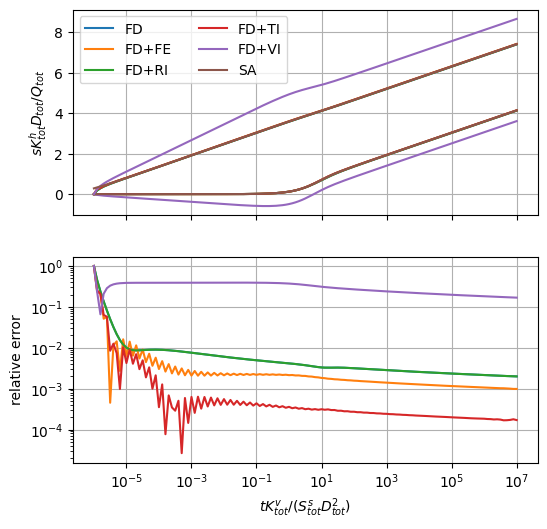

In [ ]:
# plot
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(fig.get_figheight() * 1.5)
ax0.semilogx(hemker.t, s0.T, '-');
ax0.set_prop_cycle(color=colors)
ax0.semilogx(hemker.t, s1.T, '-');
ax1.loglog(hemker.t, e.T, '-');
ax0.legend(["FD", "FD+FE", "FD+RI", "FD+TI", "FD+VI", "SA"], ncol=2);
ax0.set_ylabel("$sK_{tot}^hD_{tot}/Q_{tot}$")
ax1.set_xlabel("$tK_{tot}^v/(S_{tot}^sD_{tot}^2)$")
ax1.set_ylabel("relative error")
#ax0.set_xlim([1e-7, 1e8]);
#ax1.set_ylim((1e-9, 1e0));
ax0.grid()
ax1.grid()

### Random tests

In [ ]:
a = 10**0.1
r1 = 0.001
nr = 100
t1 = 1e-7
nt = 100

In [ ]:
# simulations
np.random.seed(2022)
n = 1000  # number of tests
err_lebbe = np.zeros((nt+1, n))
err_louw = np.zeros((nt+1, n))
err_FDTI = np.zeros((nt+1, n))
s_hemker = np.zeros((nt+1, n))

for p in range(n):

    print(p)

    nl = np.random.randint(low=2, high=10)
    D = np.random.random(nl) * 50
    D /= D.sum()
    Kh = 10 ** (np.random.randn(nl) * 1.5) + 1e-5
    Kh /= Kh.sum()
    Vani = 10 ** np.abs(np.random.randn(nl))
    Kv = Kh / Vani
    Kv /= Kv.sum()
    Ss = 1 / 10 ** np.abs(np.random.randn(nl) * 3)
    Ss /= Ss.sum()

    Q = np.zeros(nl)
    ipump = np.argmax(Kh * D)
    Q[ipump] = 1

    hemker = Hemker(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
    hemker.solve(0)
    louwyck = Louwyck(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
    louwyck.solve()
    lebbe = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
    lebbe.solve()
    FDTI = Lebbe(t1=t1, nt=nt, r1=r1, nr=nr, a=a, D=D, Kh=Kh, Kv=Kv, Ss=Ss, Q=Q)
    FDTI.radial_interpolation = False
    FDTI.time_interpolation = True
    FDTI.vertical_interpolation = False
    FDTI.solve()

    e_lebbe = np.abs(hemker.s[ipump, 0, :] - lebbe.s[ipump, 0, :]) / hemker.s[ipump, 0, :]
    e_louw = np.abs(hemker.s[ipump, 0, :] - louwyck.s[ipump, 0, :]) / hemker.s[ipump, 0, :]
    e_FDTI = np.abs(hemker.s[ipump, 0, :] - FDTI.s[ipump, 0, :]) / hemker.s[ipump, 0, :]
    err_lebbe[:, p] = e_lebbe
    err_louw[:, p] = e_louw
    err_FDTI[:, p] = e_FDTI

In [ ]:
# min and max error
max_lebbe = np.nanmax(err_lebbe, axis=1)
max_louw = np.nanmax(err_louw, axis=1)
max_FDTI = np.nanmax(err_FDTI, axis=1)
min_lebbe = np.nanmin(err_lebbe, axis=1)
min_louw = np.nanmin(err_louw, axis=1)
min_FDTI = np.nanmin(err_FDTI, axis=1)

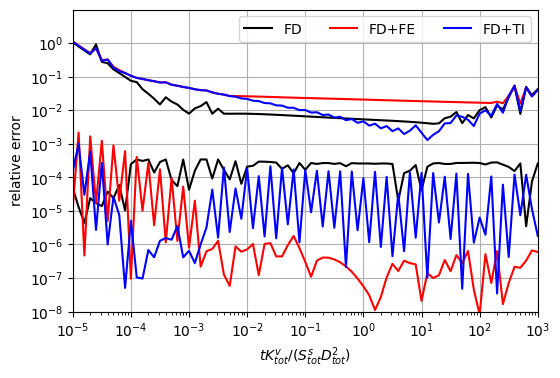

In [ ]:
# plot
plt.loglog(hemker.t, max_louw, 'k-');
plt.loglog(hemker.t, max_lebbe, 'r-');
plt.loglog(hemker.t, max_FDTI, 'b-');
plt.loglog(hemker.t, min_louw, 'k-');
plt.loglog(hemker.t, min_lebbe, 'r-');
plt.loglog(hemker.t, min_FDTI, 'b-');
plt.xlim([1e-5, 1e3]);
plt.ylim([1e-8, 10]);
plt.yticks(np.logspace(-8, 0, 9));
plt.grid();
plt.legend(['FD', 'FD+FE', 'FD+TI'], ncol=3);
plt.xlabel("$tK_{tot}^v/(S_{tot}^sD_{tot}^2)$")
plt.ylabel("relative error")
plt.savefig("random_tests.png", dpi=600)

## References

- Hemker, C. J. (1985). Transient well flow in leaky multiple-aquifer systems. Journal of Hydrology, 81(1-2), 111-126. https://doi.org/10.1016/0022-1694(85)90170-2
- Hemker, C. J. (1999). Transient well flow in vertically heterogeneous aquifers. Journal of Hydrology, 225(1-2), 1-18. https://doi.org/10.1016/S0022-1694(99)00137-7
- Lebbe, L. C. (1988). Uitvoering van pompproeven en interpretatie door middel van een invers model (in Dutch). Ghent University.
- Lebbe, L. C. (1999). Hydraulic Parameter Identification. Generalized Interpretation Method for Single and Multiple Pumping Tests. Berlin Heidelberg: Springer-Verlag. https://doi.org/10.1007/978-3-642-60117-0
- Lebbe, L. C., & de Breuck, W. (1995). Validation of an inverse numerical model for interpretation of pumping tests and a study of factors influencing accuracy of results. Journal of Hydrology, 172(1-4), 61-85. https://doi.org/10.1016/0022-1694(95)02747-D
- Louwyck, A. (2011). MAxSym - A MATLAB Tool to Simulate Two-Dimensional Axi-Symmetric Groundwater Flow. Research Unit Groundwater Modeling, Ghent University. https://github.com/alouwyck/MAxSym
- Louwyck, A., Vandenbohede, A., Bakker, M., & Lebbe, L. C. (2012). Simulation of axi-symmetric flow towards wells: A finite-difference approach. Computers & Geosciences, 44, 136-145. https://doi.org/10.1016/j.cageo.2011.09.004
- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47-49. https://doi.org/10.1145/361953.361969
- Theis, C. V. (1935). The relation between the lowering of the piezometric surface and the rate and duration of discharge of a well using ground-water storage. Transactions, American Geophysical Union, 16(2), 519-524. https://doi.org/10.1029/TR016i002p00519

---